### Adding Low-Velocity Emission
Dunham et al. and Arce & Goodman fit the opacity-corrected mass spectrum at low-velocities to subtract this from the outflow mass spectrum to estimate the outflow mass down to lower velocity channels which contain both cloud and outflow emission. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from physics import *

coord = SkyCoord(84.1505*u.deg, -6.6477*u.deg)

sub12 = extract_subcube("../../cubes/mask_imfit_12co_pix_2_Tmb.fits", region_class=RectangleSkyRegion,
                        region_kwargs=dict(width=4*u.arcmin, height=4*u.arcmin, center=coord))
sub13 = extract_subcube("../../cubes/mask_imfit_13co_pix_2_Tmb_regrid12co.fits", region_class=RectangleSkyRegion,
                        region_kwargs=dict(width=4*u.arcmin, height=4*u.arcmin, center=coord))
sub18 = extract_subcube("../../cubes/mask_imfit_c18o_pix_2_Tmb.fits", region_class=RectangleSkyRegion,
                        region_kwargs=dict(width=4*u.arcmin, height=4*u.arcmin, center=coord))


In [2]:

rms12 = rms(sub12[:,:,:40], velocity_range=[[-2,0],[18,20]]*u.km/u.s)
rms13 = rms(sub13[:,:,:40], velocity_range=[[0,2], [16,18]]*u.km/u.s)
print(rms12, rms13)

mask_outflow = np.load("mask_outflow.npy")
mask_bluelobe = np.load("mask_bluelobe.npy")
mask_redlobe = np.load("mask_redlobe.npy")
Tex = cube_Tex(sub12.with_mask(mask_outflow), average_first=True)

0.8646953701972961 K 0.38636189699172974 K


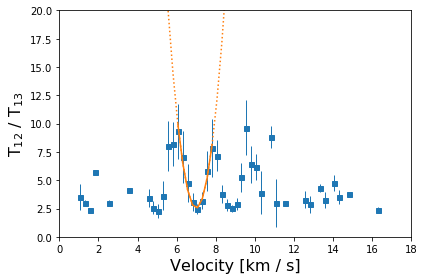

In [3]:
sub12_correctout, factor_out = opacity_correct(sub12.with_mask(mask_outflow), 
                                          sub13.with_mask(mask_outflow),
                                          snr_cutoff=3., vsys=7*u.km/u.s, plot_ratio=True,
                                          errorbar_kwargs=dict(markersize=5, marker='s', ls='', lw=1, zorder=0),           
                                          plot_kwargs=dict(c='tab:orange'),
                                          return_factor=True)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.061787843185891575
            Iterations: 38
            Function evaluations: 325
            Gradient evaluations: 38
5.074017347083475 5.0251250078307335
0.04889233925274157 solMass
0.12438335363990823 solMass
0.04986913449133628 solMass


Assuming every line core channel has an outflow mass equal to the lowest velocity blue/red lobe mass,
the total outflow mass is:
 0.24710464302937576 solMass This could be our upper limit on the outflow mass.

Assuming that the outflow has no mass in the line core, the total outflow mass is
 0.11267243094943022 solMass This could be our lower limit on the outflow mass.


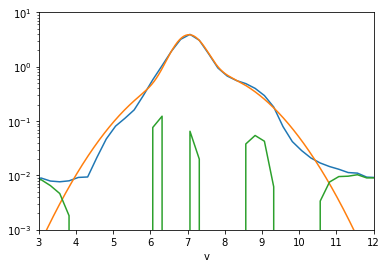

In [4]:
# plt.imshow(sub12_correctout.moment0().data)
dmdv12_correctout, masscube12_correctout = dmdv(sub12_correctout.with_mask(sub12 > 3*rms12),
    molecule='12co', Tex=Tex, return_cube=True)
dmdv12, masscube12 = dmdv(sub12.with_mask(sub12 > 3*rms12).with_mask(mask_outflow),
    molecule='12co', Tex=Tex, return_cube=True)
x, y = dmdv12_correctout.spectral_axis, dmdv12_correctout
plt.plot(x, y)
# plt.plot(dmdv12.spectral_axis, dmdv12)
dmdv12_correctout_2gauss = fit_gaussian(x, y, n_models=2,
                            gaussian_kwargs={"amplitude":[4,1]*u.Msun/(u.km/u.s), "mean":[7,9]*u.km/u.s, "stddev":[1,1.]*u.km/u.s},
                            fit_func=fitting.SLSQPLSQFitter())
plt.plot(np.linspace(0,15,1000), dmdv12_correctout_2gauss(np.linspace(0,15,1000)))
plt.plot(x, y.value-dmdv12_correctout_2gauss(x.value))
plt.semilogy()
plt.ylim(0.001, 10)
plt.xlim(3,12)
plt.xlabel("v")
print(y.value.sum()*0.250072, dmdv12_correctout_2gauss(x.value).sum()*0.250072)
print((y.value.sum()-dmdv12_correctout_2gauss(x.value).sum())*u.Msun/(u.km/u.s)*0.250072*u.km/u.s)
# print((y.value-dmdv12_correctout_2gauss(x.value)))
print(0.25*u.km/u.s*(masscube12_correctout.spectral_slab(-2*u.km/u.s, 4.7*u.km/u.s).sum() + masscube12_correctout.spectral_slab(10*u.km/u.s, 20*u.km/u.s).sum()))
print(0.25*u.km/u.s*(masscube12_correctout.with_mask(mask_bluelobe).spectral_slab(-2*u.km/u.s, 4.7*u.km/u.s).sum()))
print()
m_lowblue = 0.25*u.km/u.s*(masscube12_correctout.spectral_slab(-2*u.km/u.s, 4.7*u.km/u.s)[-1].nansum())
dmdv12_correctout_bluelobe = dmdv12_correctout[dmdv12_correctout.spectral_axis <= 4.7*u.km/u.s]
dmdv12_correctout[(dmdv12_correctout.spectral_axis > 4.7 * u.km/u.s) &
                  (dmdv12_correctout.spectral_axis < 7 *u.km/u.s)] = dmdv12_correctout_bluelobe[-1]

dmdv12_correctout_redlobe = dmdv12_correctout[dmdv12_correctout.spectral_axis >= 10.*u.km/u.s]
dmdv12_correctout[(dmdv12_correctout.spectral_axis < 10 * u.km/u.s) &
                  (dmdv12_correctout.spectral_axis > 7 *u.km/u.s)] = dmdv12_correctout_redlobe[0]
print("""
Assuming every line core channel has an outflow mass equal to the lowest velocity blue/red lobe mass,
the total outflow mass is:
""", dmdv12_correctout.sum()*0.25*u.km/u.s,
     "This could be our upper limit on the outflow mass.")

print("""
Assuming that the outflow has no mass in the line core, the total outflow mass is
""", 0.25*u.km/u.s*(dmdv12_correctout_bluelobe.sum() + dmdv12_correctout_redlobe.sum()),
    "This could be our lower limit on the outflow mass." )

### After Correcting for Opacity with a double peaked 4th order polynomial.

7.002838395753787 8.852406220606072
[7002.83839575 8852.40622061]


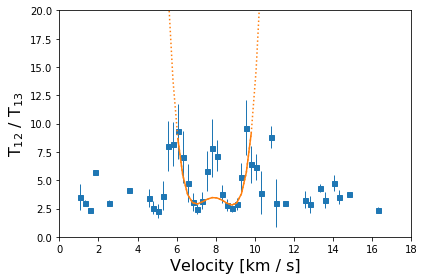

In [5]:
sub18small_hops169 = extract_subcube(sub18, region_class=CircleSkyRegion,
                                    region_kwargs=dict(center=coord, radius=15*u.arcsec))

spec18_mean = extract_spectrum(sub18small_hops169, spectral_unit=u.km/u.s)

x, y = spec18_mean.spectral_axis, spec18_mean
# print(x.to(u.km/u.s),y)
spec18_2gauss = fit_gaussian(x,y, n_models=2,
                            gaussian_kwargs={"amplitude":1.*u.K, "mean":[7,10]*u.km/u.s, "stddev":1.*u.km/u.s})
vsys1, vsys2 = spec18_2gauss.mean_0.value, spec18_2gauss.mean_1.value
print(vsys1, vsys2)
sub12_correctout, factor_out = opacity_correct(sub12.with_mask(mask_outflow), 
                                          sub13.with_mask(mask_outflow),
                                          snr_cutoff=3.,
                                          fit_func="poly4",
                                          vsys=[vsys1, vsys2]*u.km/u.s,
                                          fit_range=[6,10]*u.km/u.s,    
                                          plot_ratio=True,
                                          errorbar_kwargs=dict(markersize=5, marker='s', ls='', lw=1, zorder=0),           
                                          plot_kwargs=dict(c='tab:orange'),
                                          return_factor=True)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.1696544841283471
            Iterations: 22
            Function evaluations: 197
            Gradient evaluations: 22
10.185597368109512 10.059070076078415
0.12652729203109794 solMass
0.15601174571695367 solMass
0.0479532774591948 solMass


Assuming every line core channel has an outflow mass equal to the lowest velocity blue/red lobe mass,
the total outflow mass is:
 0.5518770066274454 solMass This could be our upper limit on the outflow mass.

Assuming that the outflow has no mass in the line core, the total outflow mass is
 0.14787203894479412 solMass This could be our lower limit on the outflow mass.


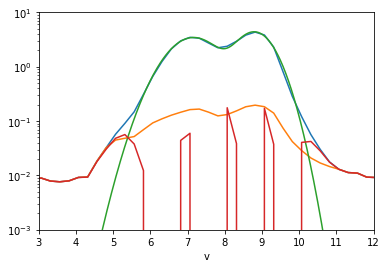

In [13]:
# plt.imshow(sub12_correctout.moment0().data)
dmdv12_correctout, masscube12_correctout = dmdv(sub12_correctout.with_mask(sub12 > 3*rms12),
    molecule='12co', Tex=Tex, return_cube=True)
dmdv12, masscube12 = dmdv(sub12.with_mask(sub12 > 3*rms12).with_mask(mask_outflow),
    molecule='12co', Tex=Tex, return_cube=True)
x, y = dmdv12_correctout.spectral_axis, dmdv12_correctout
plt.plot(x, y)
plt.plot(dmdv12.spectral_axis, dmdv12)
dmdv12_correctout_2gauss = fit_gaussian(x, y, n_models=2,
                            gaussian_kwargs={"amplitude":[4,1]*u.Msun/(u.km/u.s), "mean":[7,9]*u.km/u.s, "stddev":[1,1.]*u.km/u.s},
                            fit_func=fitting.SLSQPLSQFitter())
plt.plot(np.linspace(0,15,1000), dmdv12_correctout_2gauss(np.linspace(0,15,1000)))
plt.plot(x, y.value-dmdv12_correctout_2gauss(x.value))
plt.semilogy()
plt.ylim(0.001, 10)
plt.xlim(3,12)
plt.xlabel("v")
print(y.value.sum()*0.250072, dmdv12_correctout_2gauss(x.value).sum()*0.250072)
print((y.value.sum()-dmdv12_correctout_2gauss(x.value).sum())*u.Msun/(u.km/u.s)*0.250072*u.km/u.s)
# print((y.value-dmdv12_correctout_2gauss(x.value)))
print(0.25*u.km/u.s*(masscube12_correctout.spectral_slab(-2*u.km/u.s, 4.7*u.km/u.s).sum() + masscube12_correctout.spectral_slab(10*u.km/u.s, 20*u.km/u.s).sum()))
print(0.25*u.km/u.s*(masscube12_correctout.with_mask(mask_bluelobe).spectral_slab(-2*u.km/u.s, 4.7*u.km/u.s).sum()))
print()
m_lowblue = 0.25*u.km/u.s*(masscube12_correctout.spectral_slab(-2*u.km/u.s, 4.7*u.km/u.s)[-1].nansum())
dmdv12_correctout_bluelobe = dmdv12_correctout[dmdv12_correctout.spectral_axis <= 4.7*u.km/u.s]
dmdv12_correctout[(dmdv12_correctout.spectral_axis > 4.7 * u.km/u.s) &
                  (dmdv12_correctout.spectral_axis < 7 *u.km/u.s)] = dmdv12_correctout_bluelobe[-1]

dmdv12_correctout_redlobe = dmdv12_correctout[dmdv12_correctout.spectral_axis >= 10.*u.km/u.s]
dmdv12_correctout[(dmdv12_correctout.spectral_axis < 10 * u.km/u.s) &
                  (dmdv12_correctout.spectral_axis > 7 *u.km/u.s)] = dmdv12_correctout_redlobe[0]
print("""
Assuming every line core channel has an outflow mass equal to the lowest velocity blue/red lobe mass,
the total outflow mass is:
""", dmdv12_correctout.sum()*0.25*u.km/u.s,
     "This could be our upper limit on the outflow mass.")

print("""
Assuming that the outflow has no mass in the line core, the total outflow mass is
""", 0.25*u.km/u.s*(dmdv12_correctout_bluelobe.sum() + dmdv12_correctout_redlobe.sum()),
    "This could be our lower limit on the outflow mass." )

In [17]:
abs(y.value-dmdv12_correctout_2gauss(x.value)).sum()*0.25

9.76445228349996

In [33]:
y[(y.spectral_axis < 6*u.km/u.s) | (y.spectral_axis > 10*u.km/u.s)]
ii = (y.spectral_axis < 6*u.km/u.s) | (y.spectral_axis > 10*u.km/u.s)
np.sum((y[ii].value - dmdv12_correctout_2gauss(x[ii].value)).clip(0,100))*0.25

0.13007769606580688

In [30]:
dmdv12_correctout_2gauss(x.value)

array([5.13356786e-49, 2.28464375e-46, 8.57780695e-44, 2.71701882e-41,
       7.26051829e-39, 1.63682104e-36, 3.11310217e-34, 4.99509955e-32,
       6.76166297e-30, 7.72185231e-28, 7.43957387e-26, 6.04690616e-24,
       4.14645538e-22, 2.39871893e-20, 1.17068574e-18, 4.82014263e-17,
       1.67431841e-15, 4.90653400e-14, 1.21302618e-12, 2.53002103e-11,
       4.45181069e-10, 6.60857531e-09, 8.27632618e-08, 8.74431817e-07,
       7.79422437e-06, 5.86109087e-05, 3.71828439e-04, 1.99005625e-03,
       8.98559209e-03, 3.42284037e-02, 1.09998102e-01, 2.98223823e-01,
       6.82115773e-01, 1.31623263e+00, 2.14273373e+00, 2.94297506e+00,
       3.41173005e+00, 3.34888725e+00, 2.83778814e+00, 2.27579736e+00,
       2.20326425e+00, 2.90218956e+00, 3.95197974e+00, 4.38849906e+00,
       3.66578379e+00, 2.25474577e+00, 1.01538771e+00, 3.34234058e-01,
       8.03755107e-02, 1.41179008e-02, 1.81117058e-03, 1.69699364e-04,
       1.16126372e-05, 5.80386517e-07, 2.11864667e-08, 5.64942574e-10,
      

In [31]:
dmdv12_correctout_redlobe

<Quantity [0.12089683, 0.05633162, 0.03012802, 0.01772888, 0.01299099,
           0.01130389, 0.01102932, 0.00931048, 0.00915063, 0.00846075,
           0.00801483, 0.00737495, 0.00826903, 0.00704922, 0.00821179,
           0.00733386, 0.00570833, 0.00633648, 0.00678036, 0.00425559,
           0.00481425, 0.00438712, 0.00503828, 0.00459833, 0.00301376,
           0.00351248, 0.00357702, 0.00337405, 0.00287797, 0.00315307,
           0.00275289, 0.00116788, 0.00060075, 0.00080645, 0.00080116,
           0.00057433, 0.00104854, 0.00085305] s solMass / km>